Strategy Principle:
Create a 20-day (+/- 2 standard deviations) Bollinger band over the adjusted closing price. Buy when the price crosses a lower range from the top and hold until the next time the price crosses a higher range from below. Sell when the price crosses the upper band from the bottom and hold until the next time the price crosses the lower band.

In [9]:
#Importing necessary libraries
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
#quantopian
import pyfolio as pf
import datetime as dt
import pandas_datareader.data as web
import os
import warnings

In [11]:
#Ignore printing all warnings
warnings.filterwarnings('ignore')


In [12]:
#print all outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [13]:
#Download the required stock data from Yahoo Finance (OHLCV Data)
_start = dt.date(2015,1,2)
_end = dt.date(2020,4,30)
ticker = 'MSFT'
df = yf.download(ticker, start = _start, end = _end)

[*********************100%***********************]  1 of 1 completed


The daily return of the strategy is calculated and compared with the return of the buy-and-hold strategy, which becomes the benchmark or comparison strategy. In other words, it checks to see if the strategy will do better than simply buying and holding the stock, and a good strategy will generally do better than a buy-and-hold strategy.

In [14]:
df['bnh_returns'] = np.log(df['Adj Close']/df['Adj Close'].shift(1))
df.head(3)

,Open,High,Low,Close,Adj Close,Volume,bnh_returns
Date,,,,,,,
2015-01-02,46.660000,47.419998,46.540001,46.759998,40.926437,27913900,NaN
2015-01-05,46.369999,46.730000,46.250000,46.330002,40.550091,39673900,-0.009238
2015-01-06,46.380001,46.750000,45.540001,45.650002,39.954926,36447900,-0.014786


In [15]:
#Create Bollinger band indicators
df['ma20'] = df['Adj Close'].rolling(window=20).mean()
df['std'] = df['Adj Close'].rolling(window=20).std()
df['upper_band'] = df['ma20'] + (2 * df['std'])
df['lower_band'] = df['ma20'] - (2 * df['std'])
df.drop(['Open','High','Low'],axis=1,inplace=True,errors='ignore')
df.tail(5)


,Close,Adj Close,Volume,bnh_returns,ma20,std,upper_band,lower_band
Date,,,,,,,,
2020-04-23,171.419998,167.577637,32790800,-0.012176,161.229686,8.549667,178.329020,144.130352
2020-04-24,174.550003,170.637466,34277600,0.018094,162.131020,8.543426,179.217871,145.044168
2020-04-27,174.050003,170.148682,33194400,-0.002869,163.321230,7.859116,179.039462,147.602997
2020-04-28,169.809998,166.003693,34392700,-0.024663,163.789491,7.717715,179.224920,148.354062
2020-04-29,177.429993,173.452911,51286600,0.043896,164.753389,7.657331,180.068051,149.438727


The next step is to create the most critical part of the strategy. It includes generating the long and short signals mentioned in the strategy, generating the long and short positions. The signals are essentially indicators that indicate the action that needs to be taken (i.e., buy or sell). A position is the position you hold after you have bought or sold (i.e., gone long or short).

In [28]:
#BUY condition
df['signal'] = np.where((df['Adj Close'] < df['lower_band']) &
(df['Adj Close'].shift(1) >= df['lower_band']),1,0)

In [29]:
#SELL condition 1,0,-1
df['signal'] = np.where((df['Adj Close'] > df['upper_band']) &
(df['Adj Close'].shift(1) <= df['upper_band']),-1,df['signal'])

In [30]:
#creating long and short positions
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

In [31]:
#shifting by 1, to account of close price return calculations
df['position'] = df['position'].shift(1)

df.tail(5)

,Close,Adj Close,Volume,bnh_returns,ma20,std,upper_band,lower_band,signal,position
Date,,,,,,,,,,
2020-04-23,171.419998,167.577637,32790800,-0.012176,161.229686,8.549667,178.329020,144.130352,0,1.0
2020-04-24,174.550003,170.637466,34277600,0.018094,162.131020,8.543426,179.217871,145.044168,0,1.0
2020-04-27,174.050003,170.148682,33194400,-0.002869,163.321230,7.859116,179.039462,147.602997,0,1.0
2020-04-28,169.809998,166.003693,34392700,-0.024663,163.789491,7.717715,179.224920,148.354062,0,1.0
2020-04-29,177.429993,173.452911,51286600,0.043896,164.753389,7.657331,180.068051,149.438727,0,1.0


<AxesSubplot: xlabel='Date'>

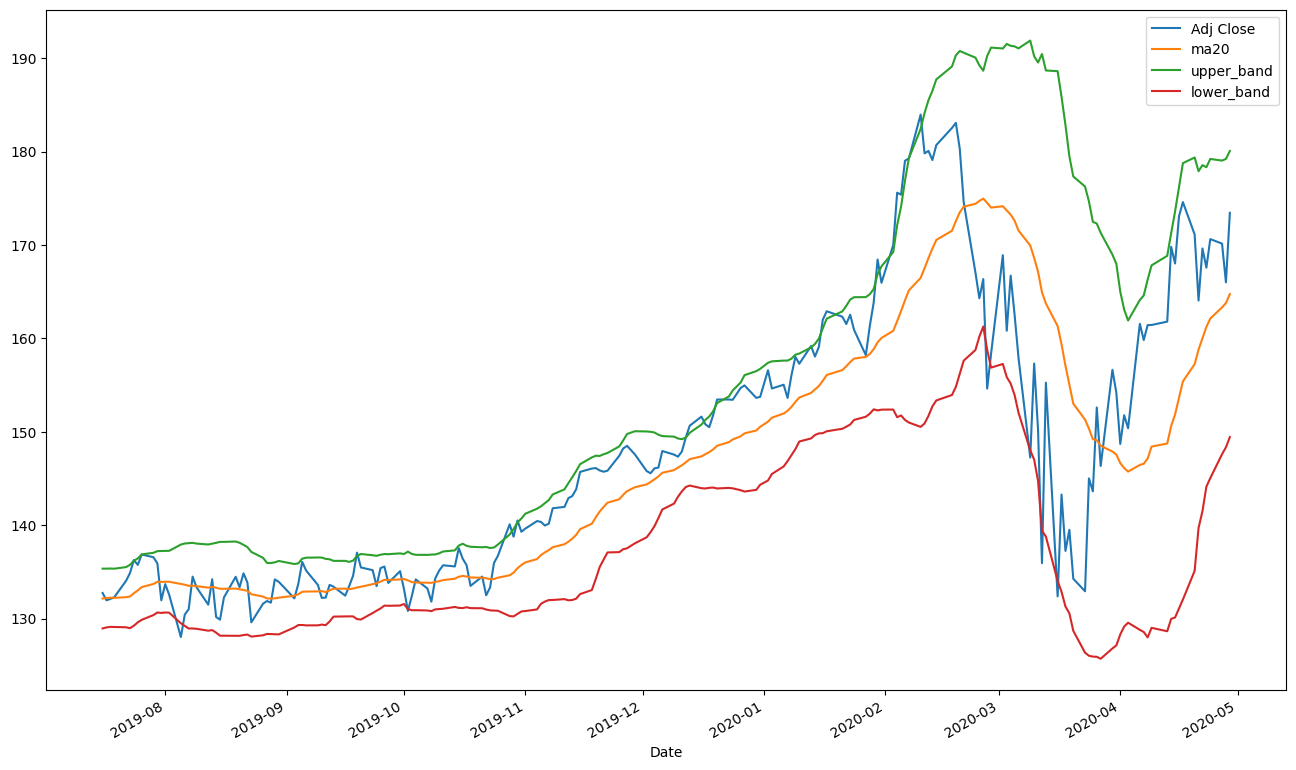

In [32]:
df[['Adj Close','ma20','upper_band','lower_band']].tail(200).plot(figsize = (16,10))

<AxesSubplot: xlabel='Date'>

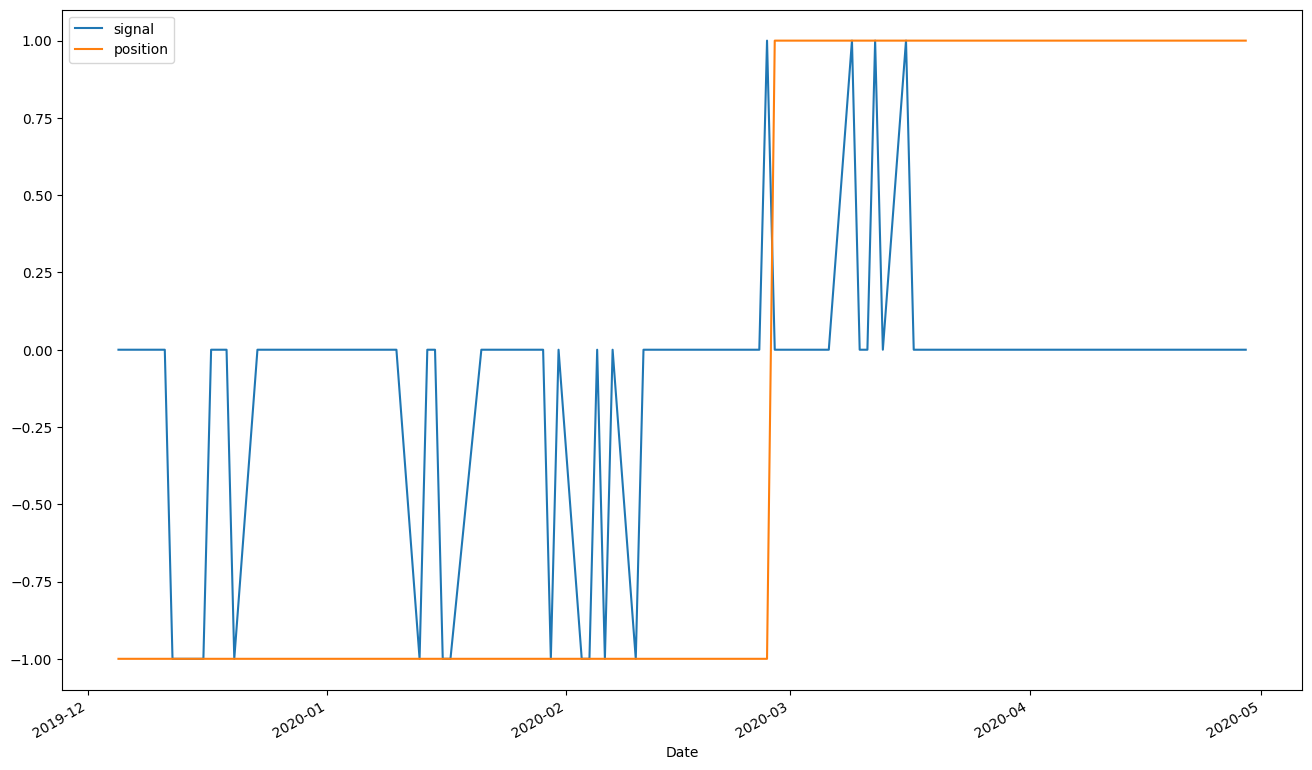

In [33]:
df[['signal','position']].tail(100).plot(figsize = (16,10))

In [ ]:
#Compare buy-and-hold strategies with Bollinger Band Strategies (1)
